In [8]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science','ieee', "no-latex", "std-colors"])

ars_path = "/home/boittier/AdjustReference-System/"
sys.path.insert(1, ars_path)
from ARS import *

def get_FDCM_data(path, csv_name):
    subdirs = [x for x in os.listdir(path) if 
               os.path.isdir(os.path.join(path, x)) and not x.startswith(".")]

    if "slices" in subdirs:
        subdirs.remove("slices")
        
    scan_points = []
    dihedrals = []
    closes = []
    mids = []
    fars = []
    totals = []
    paths = []
    rmsd_atoms = []
    rmsd_charges = []
    q_s = []
    
    tmp_dict = {}
    
    scan_points.append("0_0")
    paths.append(path)
    ars_lines = open(os.path.join(path, "ARS.log")).readlines()
    rmsd_atoms.append(float(ars_lines[0].split()[-1]))
    rmsd_charges.append(float(ars_lines[1].split()[-1]))
    dihedrals.append(float(ars_lines[2].split()[-1]) * -1)
    
    analysis_lines = open(os.path.join(path, "analysis.log")).readlines()
    totals.append(float(analysis_lines[-5].split()[-3]))
    closes.append(float(analysis_lines[-4].split()[-3]))
    mids.append(float(analysis_lines[-3].split()[-3]))
    fars.append(float(analysis_lines[-2].split()[-3]))
    
    local_file = open(os.path.join(path, "local_0_fit.xyz")).readlines()
    n_lines = int(local_file[0])
    charges = local_file[2:n_lines+2]
    charges = np.array([ [float(x.split()[1]),
              float(x.split()[2]),
              float(x.split()[3]),
              float(x.split()[4])] for x in charges])
    
    for i, axis in enumerate(["x", "y", "z", "q"]):
        for c in range(n_lines):
            if f"{axis}_c{c}" not in tmp_dict.keys():
                tmp_dict[f"{axis}_c{c}"] = []
            tmp_dict[f"{axis}_c{c}"].append(charges[c,i])

    for x in subdirs:
        #  list files in the subdir
        files = os.listdir(os.path.join(path, x))
        local = [x for x in files if x.startswith("local")]
#         print(local)
        #  read the charges in their local axes
        local_file = open(os.path.join(path, x, local[-1])).readlines()
        n_lines = int(local_file[0])
        charges = local_file[2:n_lines+2]
        charges = np.array([ [float(x.split()[1]),
                  float(x.split()[2]),
                  float(x.split()[3]),
                  float(x.split()[4])] for x in charges])
        
        for i, axis in enumerate(["x", "y", "z", "q"]):
            for c in range(n_lines):
                if f"{axis}_c{c}" not in tmp_dict.keys():
                    tmp_dict[f"{axis}_c{c}"] = []
                tmp_dict[f"{axis}_c{c}"].append(charges[c,i])
        
        scan_points.append(x)
        paths.append(os.path.join(path, x))
        #  read the ARS log file
        ars_lines = open(os.path.join(path, x, "ARS.log")).readlines()
        
        rmsd_atoms.append(float(ars_lines[0].split()[-1]))
        rmsd_charges.append(float(ars_lines[1].split()[-1]))
        dihedrals.append(float(ars_lines[2].split()[-1]))
        #  read the analysis log file
        analysis_lines = open(os.path.join(path, x, "analysis.log")).readlines()
        
        totals.append(float(analysis_lines[-5].split()[-3]))
        closes.append(float(analysis_lines[-4].split()[-3]))
        mids.append(float(analysis_lines[-3].split()[-3]))
        fars.append(float(analysis_lines[-2].split()[-3]))
        
    df_dict = {"scan_point": scan_points, "dihedral": dihedrals, "close_range": closes, 
              "mid_range": mids, "far_range": fars, "total": totals,  
              "rmsd_atoms": rmsd_atoms, "rmsd_charges": rmsd_charges, "path": paths}
    df_dict.update(tmp_dict)
    df = pd.DataFrame(df_dict)
    df.to_csv("/home/unibas/boittier/FDCM/data_csv/"+csv_name, index=False)    
    df = df.sort_values("dihedral")
    
    return df    
    
def plot_fit_dataframe(df):
    plt.grid(which="both")
    plt.plot(df["dihedral"], df["total"], "-", label="Total")        
    plt.plot(df["dihedral"], df["close_range"], "-", label="1.20 < $r$ < 1.66") 
    plt.plot(df["dihedral"], df["mid_range"], "-", label="1.66 < $r$ < 2.20") 
    plt.plot(df["dihedral"], df["far_range"], "-", label="2.20 < $r$") 
    plt.legend()
    plt.ylabel("ESP Error (kcal mol$^{-1}$ $e^{-1}$)")
    plt.xlabel("$\Phi~(^{\circ})  $")
    plt.ylim(0, 10)
    plt.xlim(-180,180)
    
def plot_charge(c_number, df, prefix):
    df = df[df["dihedral"] < 0]
    
    
    fig, ax = plt.subplots(3,1,  sharex=True)
    #df = df.drop(35)
    ax[0].scatter(df["dihedral"], df[f"x_c{c_number}"], s=0.5, c="red")
    ax[1].scatter(df["dihedral"], df[f"y_c{c_number}"], s=0.5, c="green")
    ax[2].scatter(df["dihedral"], df[f"z_c{c_number}"], s=0.5, c="blue")

    fit_x = fit_sin(df["dihedral"], df[f"x_c{c_number}"])
    ax[0].plot(df["dihedral"], fit_x["fitfunc"](df["dihedral"]), "--", c="k", linewidth=0.675)
    fit_y = fit_sin(df["dihedral"], df[f"y_c{c_number}"])
    ax[1].plot(df["dihedral"], fit_y["fitfunc"](df["dihedral"]), "--", c="k", linewidth=0.675)
    fit_z = fit_sin(df["dihedral"], df[f"z_c{c_number}"])
    ax[2].plot(df["dihedral"], fit_z["fitfunc"](df["dihedral"]), "--", c="k", linewidth=0.675)
    
    ax[0].plot(df["dihedral"], df[f"x_c{c_number}"], "--", c="red")
    ax[1].plot(df["dihedral"], df[f"y_c{c_number}"], "--", c="green")
    ax[2].plot(df["dihedral"], df[f"z_c{c_number}"], "--", c="blue")
    
    ax[0].set_ylabel("$e_x$")
    ax[1].set_ylabel("$e_y$")
    ax[2].set_ylabel("$e_z$")
    plt.xlabel('$\Phi$')
    
    fits_ = [fit_x, fit_y, fit_z]
    
    for i in range(3):
        plt.text(0.5, 0.5, f"$q_{{{c_number+1}}}$", 
                 rotation=0, verticalalignment="center", 
                 transform= ax[i].transAxes)
        
#         covariance = fits_[i]["maxcov"]
#         plt.text(1,1, "$\sigma_{X,Y}$ ="+"{:.3e}".format(covariance), 
#                  rotation=0, verticalalignment="center", 
#                  transform= ax[i].transAxes)
    plt.savefig("../figs/charge_position_analysis/{0}-fbuta_sym_c{1}.pdf".
                format(prefix, c_number+1))
    
    plt.xlim(-180,0)
    plt.show()
    
    return [fit_x["fitfunc"], fit_y["fitfunc"], fit_z["fitfunc"]]
    
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=10000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, 
            "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}



In [9]:
df_f0 = get_FDCM_data("../models/fbuta-f_0", "fbuta-f0.csv")
df_f10 = get_FDCM_data("../fbuta-f_10", "fbuta-f10.csv")

df_c0 = get_FDCM_data("../fbuta-c_0", "fbuta-c0.csv")
df_c1 = get_FDCM_data("../fbuta-c_1", "fbuta-c1.csv")
df_c10 = get_FDCM_data("../fbuta-c_10", "fbuta-c10.csv")

df_t_c0 = get_FDCM_data("../t-fbuta-c_0", "t-fbuta-c0.csv")
df_t_c10 = get_FDCM_data("../t-fbuta-c_10", "t-fbuta-c10.csv")


FileNotFoundError: [Errno 2] No such file or directory: '../models/fbuta-f_0'

In [5]:
key = "total"
# plt.grid(which="both")
#plt.axhline(0.47, c="gray", label="Differential Evolution")

rand = np.random.rand(len(df_f0["dihedral"]))
rand = 0.45 + rand*0.1
plt.plot(df_f0["dihedral"], rand, "--", c="grey", alpha=0.5, label="Differential Evolution")

plt.plot(df_f0["dihedral"], df_f0[key], "-", label="MDCM E$_{min}$ → $\Phi$", c="#eb4034")     

plt.plot(df_f10["dihedral"][1:-1], df_f10[key][1:-1], "-", label="f-MDCM gradient following") 


data = [3.969113044E-01, 4.046986636E-01, 4.230986375E-01, 4.643317823E-01, 5.675696228E-01, 7.707507970E-01, 9.373175273E-01, 9.687092591E-01, 9.251743261E-01, 7.153200014E-01, 6.526345712E-01, 6.142589882E-01, 5.991791416E-01, 5.975759533E-01, 6.073530288E-01, 6.196128634E-01, 6.270556120E-01, 6.268317568E-01, 6.337099090E-01, 6.600030199E-01, 7.198476250E-01, 8.011735583E-01, 9.077820308E-01, 1.010036785E+00, 1.113081759E+00, 1.169022761E+00, 1.149256116E+00, 9.933021642E-01, 7.670221520E-01, 5.965333294E-01, 4.941390200E-01, 4.441259433E-01, 4.546767592E-01, 4.971742520E-01, 5.596187772E-01]
plt.plot(df_f0["dihedral"][1:-1], data, label="f-MDCM $\sin(\Phi)$ fit")


#plt.plot(df_c10["dihedral"], df_c10[key], "-", label="MDCM E$_{min}$ → $\Phi$ + GD")  
#plt.plot(df_t_c0["dihedral"], df_t_c0[key], "-", label="MDCM E$_{TS}$ → $\Phi$")   
#plt.plot(df_t_c10["dihedral"], df_t_c10[key], "-", label="MDCM E$_{TS}$ → $\Phi$ + GD")

plt.ylabel("$\Delta$ESP (kcal mol$^{-1}$ $e^{-1}$)")
plt.xlabel("$\Phi~(^{\circ})  $")
plt.ylim(0, 2)
plt.xlim(-170,0)




# plt.legend(bbox_to_anchor=(1.0115, 0.48))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("summary.pdf")



#  0.49  # 0.48 # 0.48




NameError: name 'df_f0' is not defined

In [6]:
fit_functions = []

for i in range(21):
    _ = plot_charge(i, df_f10,"a")
    fit_functions.append(_)
    
# fit_functions



NameError: name 'df_f10' is not defined

In [ ]:
for i in range(1):
    _ = plot_charge(i, df_f10,"a")
    fit_functions.append(_)
plt.savefig()

In [5]:
keys = ["dihedral"]
fit_df_dict = {"dihedral": df_f10["dihedral"]}
fit_df_dict["path"] = df_f10["path"]

for c in range(21):
    key = f"q_c{c}"
    fit_df_dict[key] = df_f10[key]
    for i, axis in enumerate(["x", "y", "z"]):

        keys.append(f"{axis}_c{c}")
        fit_df_dict[f"{axis}_c{c}"] = fit_functions[c][i](df_f10["dihedral"])
        
        
fit_df = pd.DataFrame(fit_df_dict)   
diff_df = fit_df - df_f10[keys]

sqr_df = diff_df **2 
rmsd = np.sqrt(sqr_df.sum()/21)
rmsd.sum()

0.22983767942899297

In [7]:
n_charges = 21
header = "s                      x[A]                      y[A]                      z[A]                      q[e]\n"

cube_path_format = "/home/unibas/boittier/RDKit_G2/B.pdb/SCAN_1_2_3_4_S_36_10.0/{}_SCAN/B.p.cube"
frame_file = "/home/unibas/boittier/pydcm-1.2/models/test3/frames.txt" 

for row in fit_df.iterrows():
    path = row[1]["path"]
    path_split = path.split("/")
    path_split[1] = "fit_" + path_split[1]
    new_path = os.path.join(*path_split)
    
    try:
        os.mkdir(new_path)
    except FileExistsError:
        pass
    
    fitted_local = []
    
    new_xyz_file = os.path.join(new_path, "fitted_local.xyz")
    nf = open(new_xyz_file, "w")
    nf.write(f"{n_charges}\n")
    nf.write(header)
    for c in range(n_charges):
        values = []
        for j, axis in enumerate(["x", "y", "z", "q"]):
            values.append(row[1][f"{axis}_c{c}"])
            
        if values[3] > 0:
            c_name = "N"
        else:
            c_name = "O"
        nf.write("{0:} {1:.16f} {2:.16f} {3:.16f} {4:.16f}\n".format(c_name, *values))
        
        fitted_local.append(values[:-1])
        
    nf.close()
    
    if len(new_path) == 2:
        scan_point = "0"
    else:
        scan_point = path_split[-1].split("_")[-1]
    
    pcube = cube_path_format.format(scan_point)
    
    old_global_xyz = os.path.join(path, "refined.xyz")
    
    ars_obj = ARS(old_global_xyz, pcube, frame_file, pcube_2=pcube)
    
    ars_obj.set_local_charge_positions(np.array(fitted_local)) 

    cp = ars_obj.local_to_global()
    ars_obj.set_charge_positions_plus(cp)
    
    ars_obj.save_charges_global(os.path.join(new_path, "fitted_global.xyz"))

    
            
    
    
    
        
    

NameError: name 'fit_df' is not defined

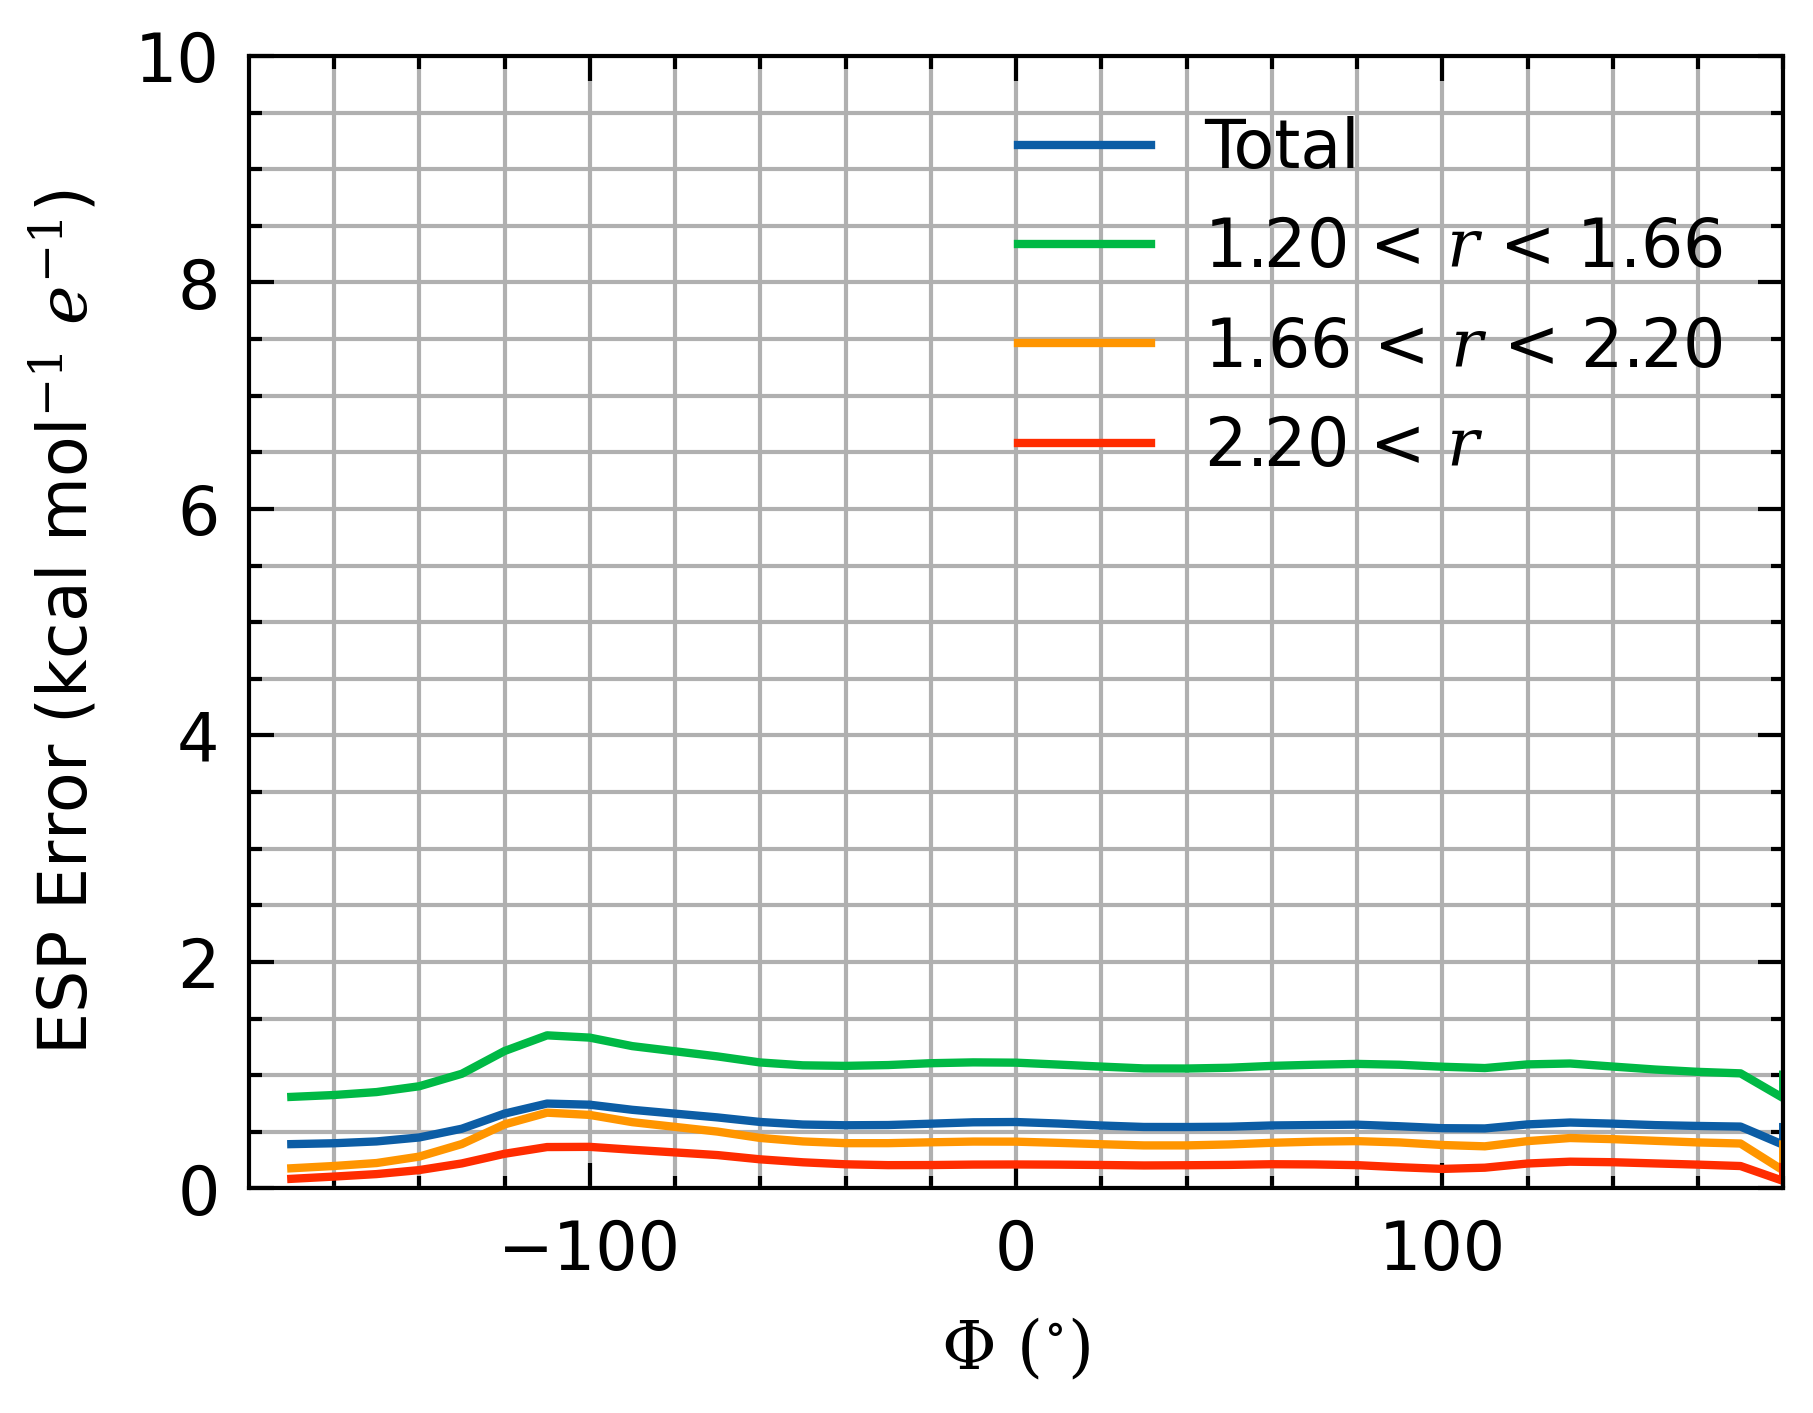

In [149]:
plot_fit_dataframe(df_f10)
plt.savefig("fbuta_f10.png")


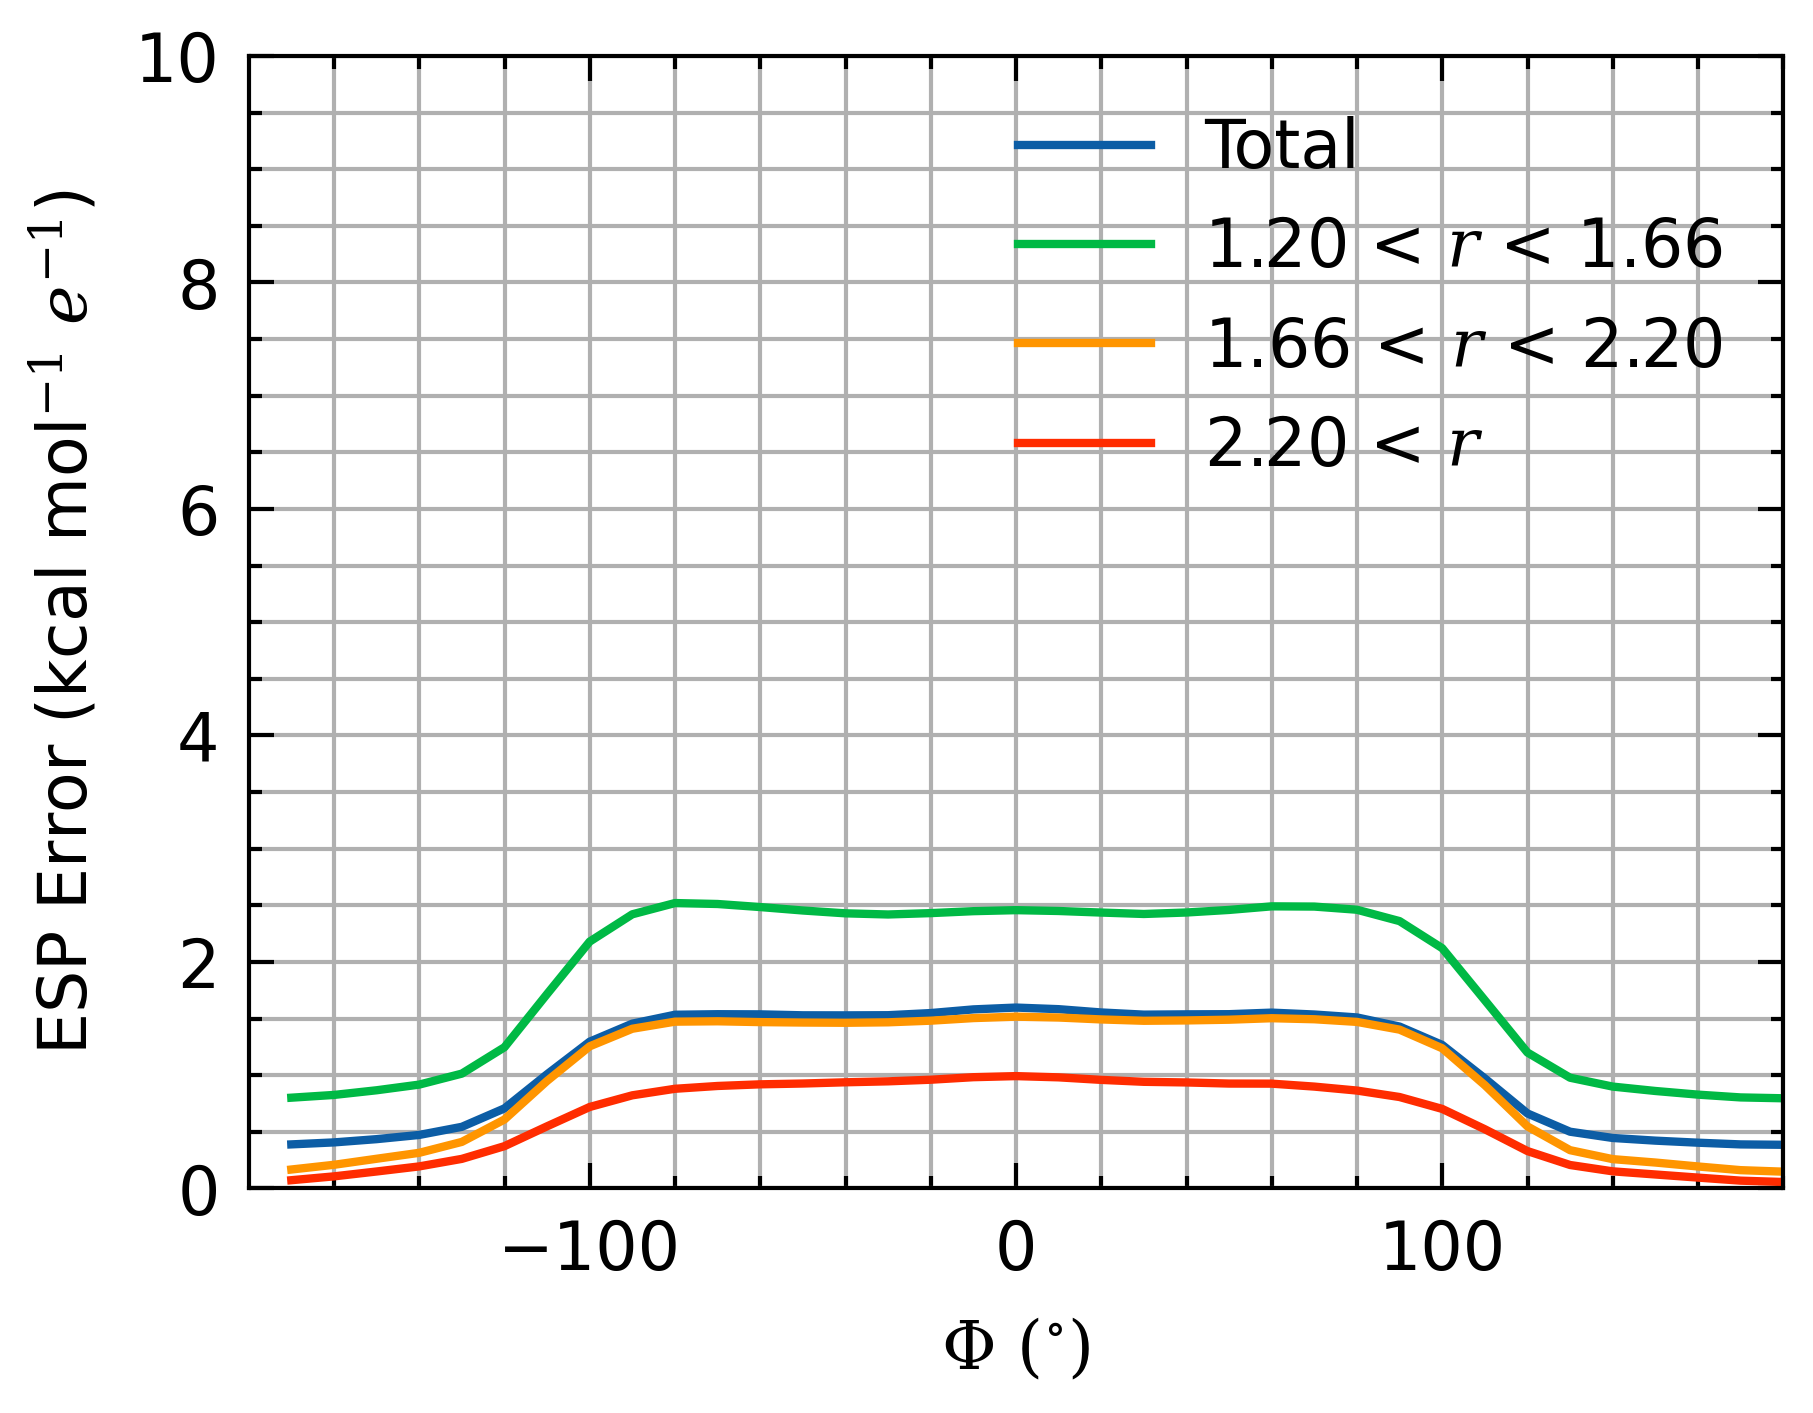

In [134]:
plot_fit_dataframe(df_c0)
plt.savefig("fbuta_c0.png")

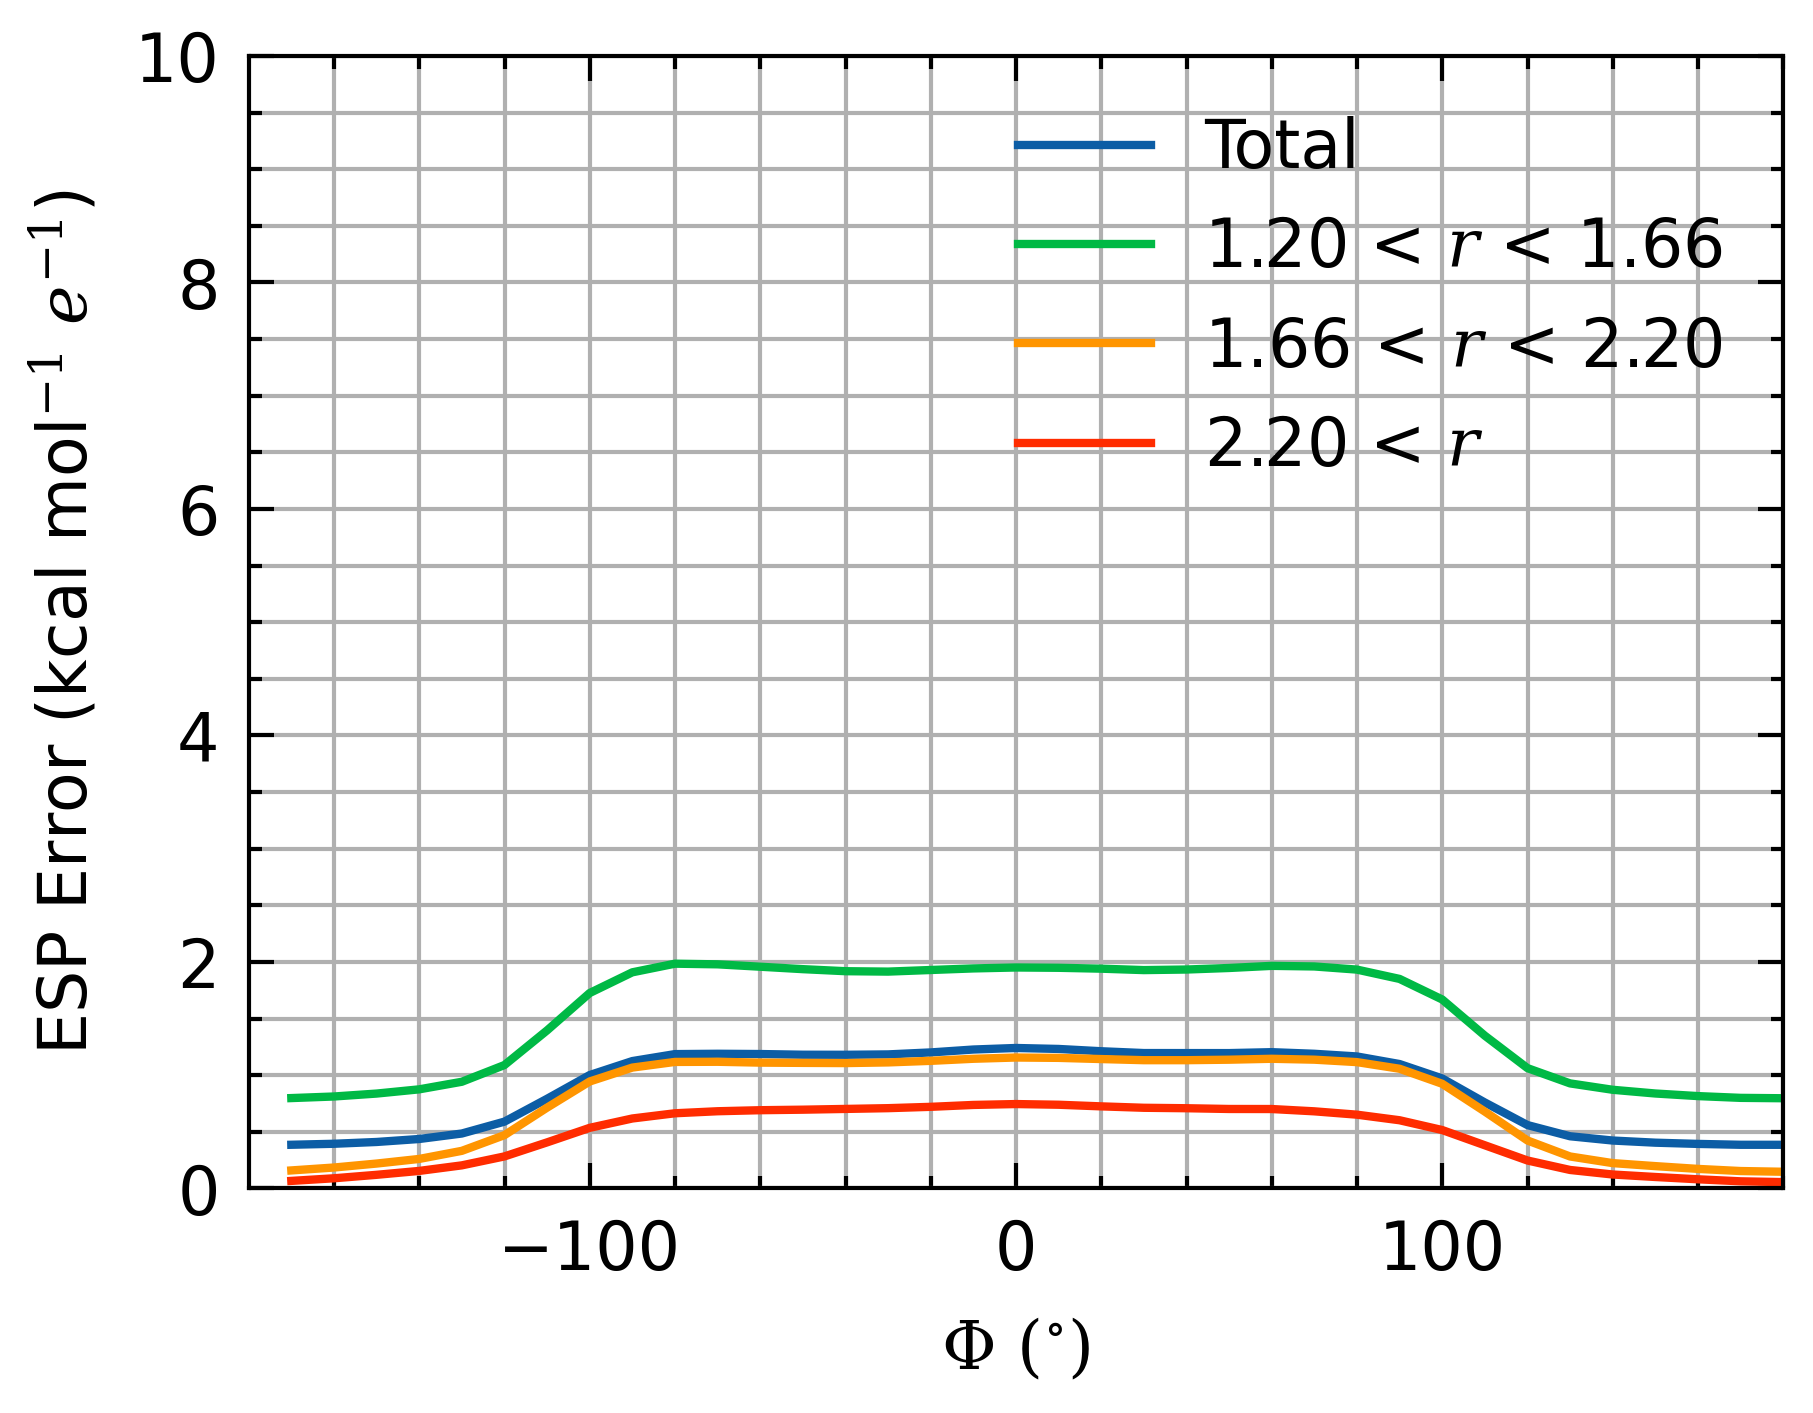

In [135]:
plot_fit_dataframe(df_c10)
plt.savefig("fbuta_c10.png")

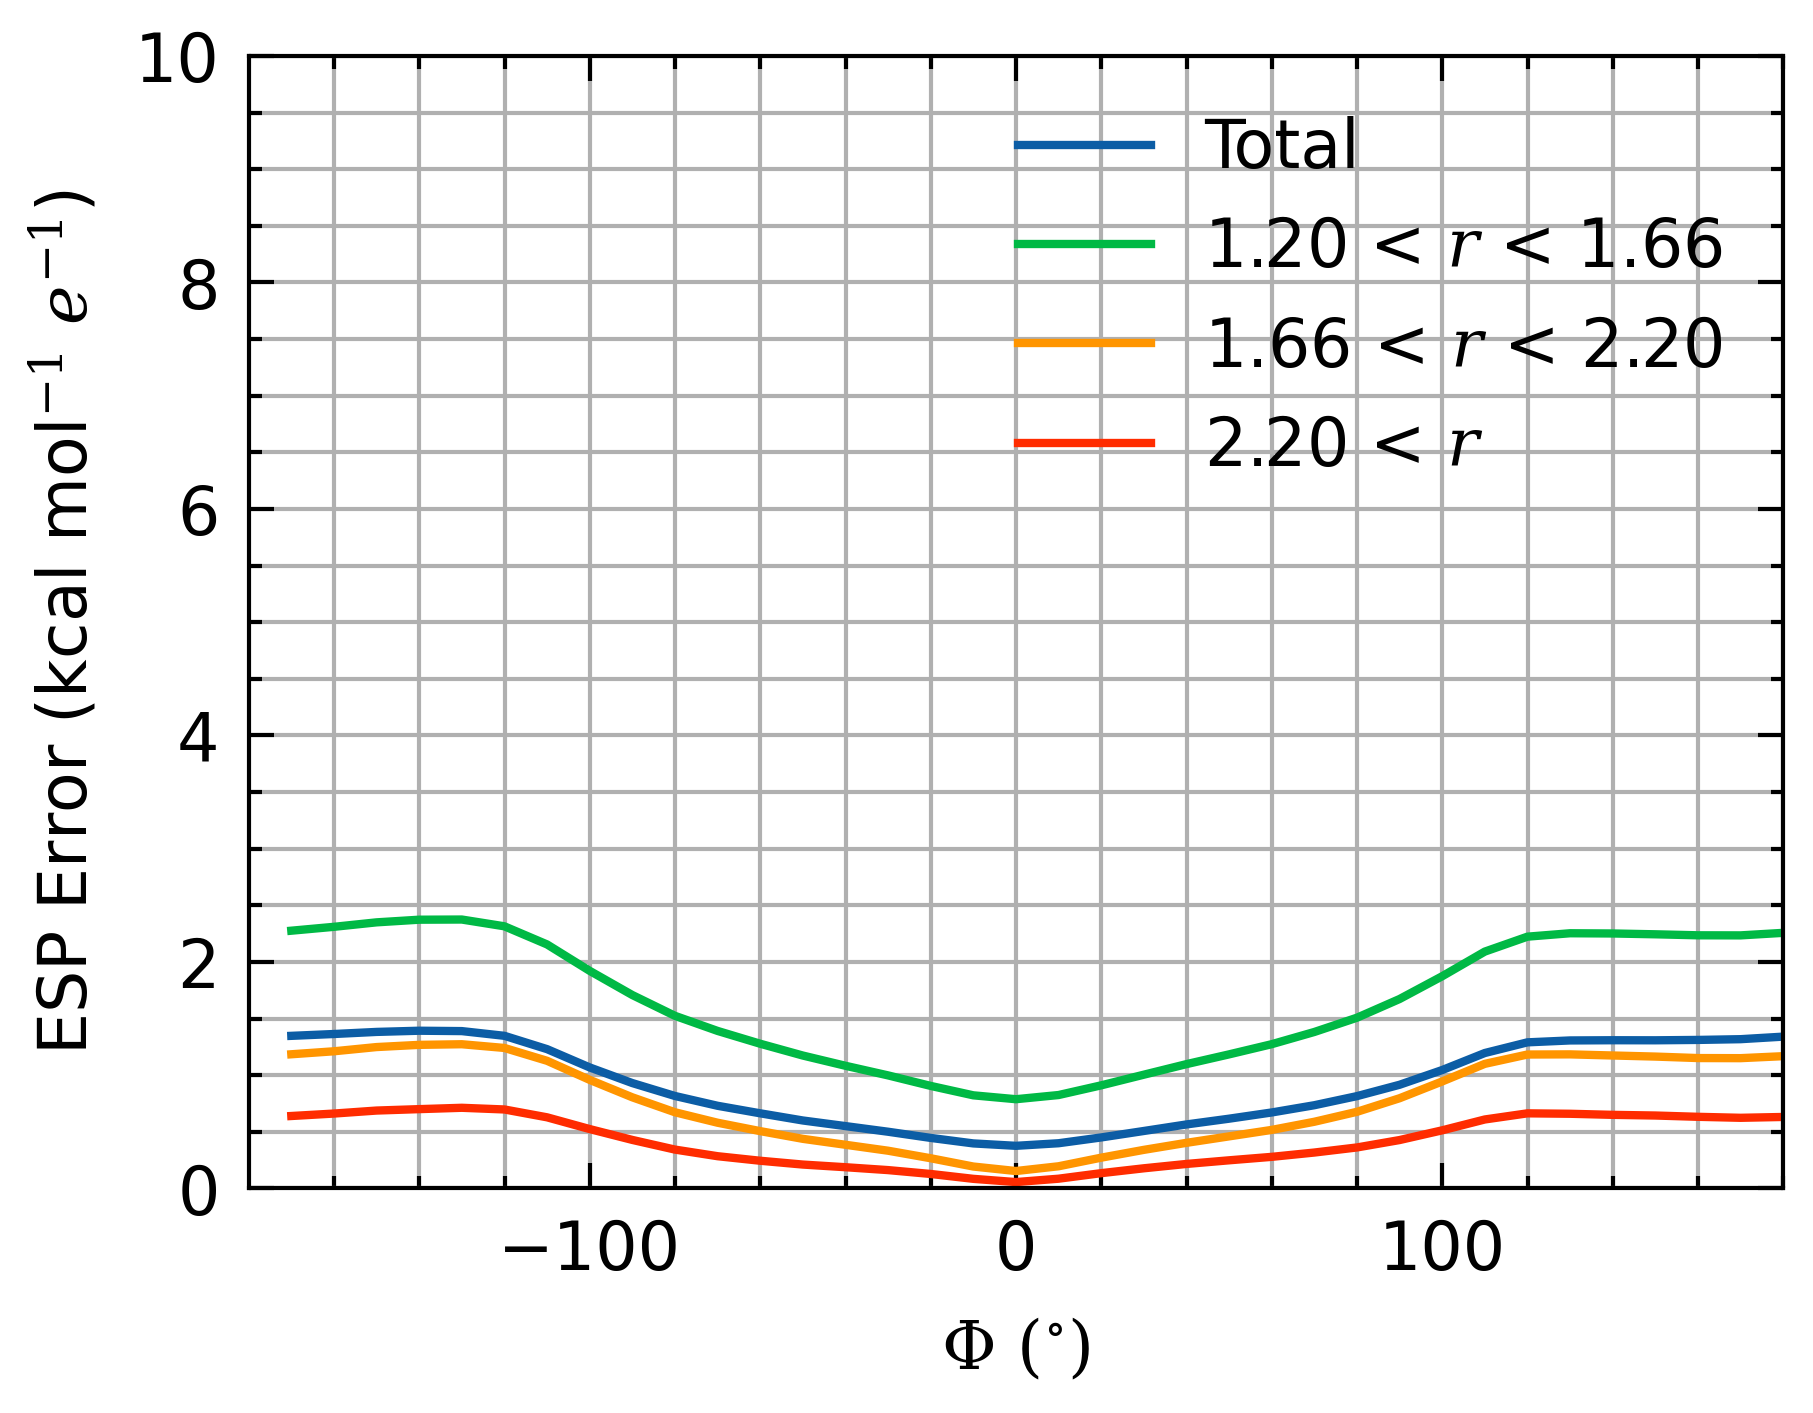

In [136]:
plot_dataframe(df_t_c0)
plt.savefig("fbuta_t0.png")

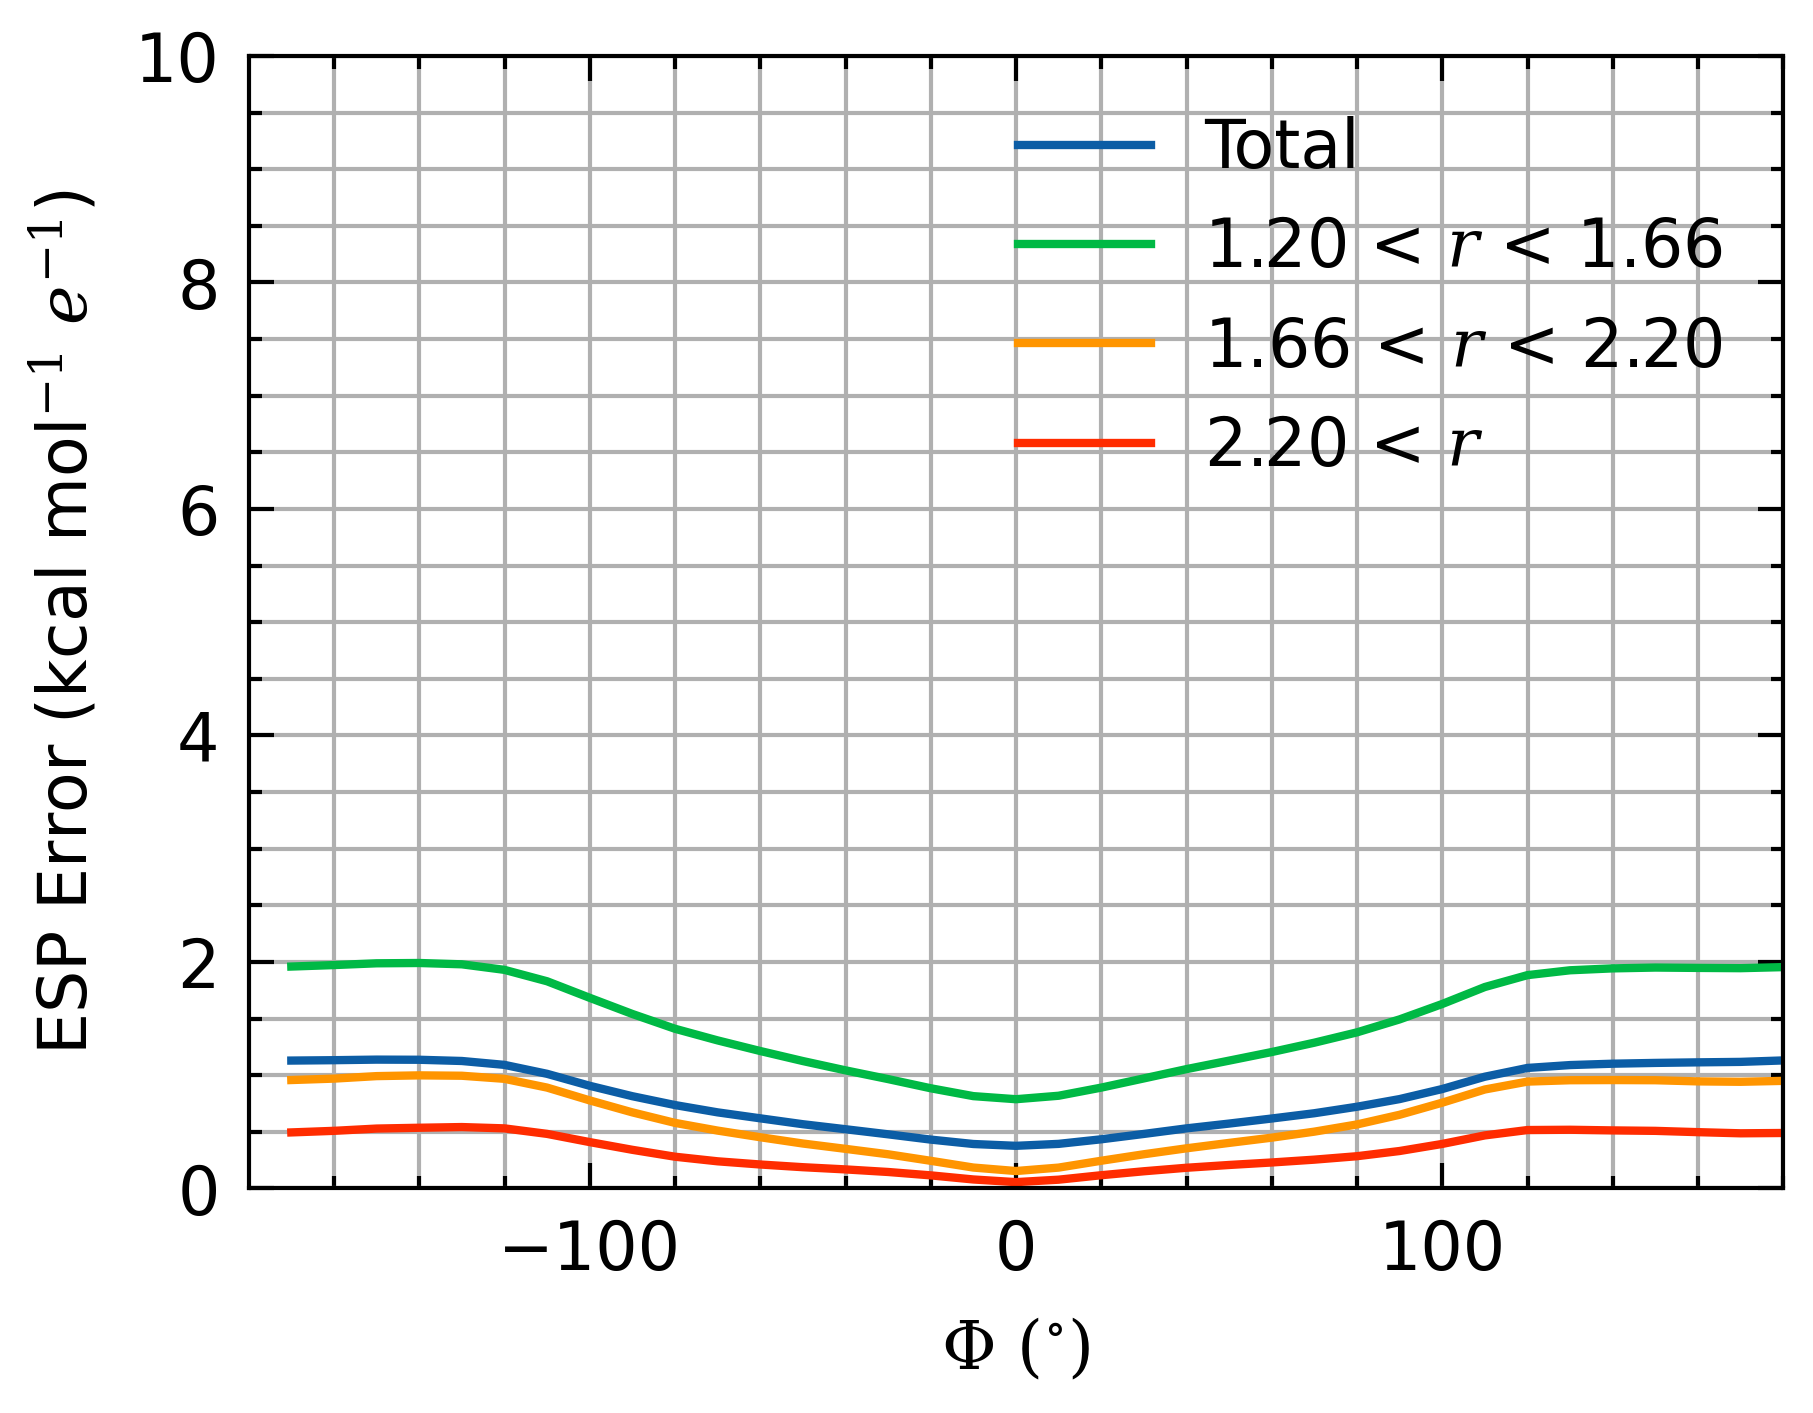

In [139]:
plot_dataframe(df_t_c10)
plt.savefig("fbuta_t10.png")